In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

random.seed(108)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
!pwd

In [4]:
%mkdir Road_Sign_Dataset
%cd Road_Sign_Dataset
!mkdir annotations
!mkdir images

/kaggle/working/Road_Sign_Dataset


In [5]:
%cd /kaggle/working/Road_Sign_Dataset
!ls

/kaggle/working/Road_Sign_Dataset
annotations  images


In [ ]:
#!rm -R Road_Sign_Dataset

In [6]:
!cp -R /kaggle/input/tbx-11/TBX11K/annotations/xml/* /kaggle/working/Road_Sign_Dataset/annotations
!cp -R /kaggle/input/tbx-11/TBX11K/imgs/tb/* /kaggle/working/Road_Sign_Dataset/images

In [7]:
!pwd
!ls

/kaggle/working/Road_Sign_Dataset
annotations  images


In [8]:
# Assuming you're in the data folder
!cat /kaggle/working/Road_Sign_Dataset/annotations/tb0004.xml

<annotation>
	<filename>tb0004</filename>
	<segmented>0</segmented>
	<size>
		<width>1852</width>
		<height>2022</height>
	</size>
	<object>
		<name>ActiveTuberculosis</name>
		<pose>unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>469</xmin>
			<ymin>228</ymin>
			<xmax>890</xmax>
			<ymax>603</ymax>
		</bndbox>
	</object>
	<object>
		<name>ActiveTuberculosis</name>
		<pose>unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>1177</xmin>
			<ymin>317</ymin>
			<xmax>1503</xmax>
			<ymax>728</ymax>
		</bndbox>
	</object>
</annotation>


In [9]:
root = ET.parse('/kaggle/working/Road_Sign_Dataset/annotations/tb0026.xml').getroot()
root

<Element 'annotation' at 0x79b07d86b880>

In [10]:
# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text + '.xml'
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict

In [11]:
import os
os.remove('/kaggle/working/Road_Sign_Dataset/annotations/tb1199.xml')
os.remove('/kaggle/working/Road_Sign_Dataset/images/tb1199.png')

In [12]:
print(extract_info_from_xml('/kaggle/working/Road_Sign_Dataset/annotations/tb0004.xml'))

{'bboxes': [{'class': 'ActiveTuberculosis', 'xmin': 469, 'ymin': 228, 'xmax': 890, 'ymax': 603}, {'class': 'ActiveTuberculosis', 'xmin': 1177, 'ymin': 317, 'xmax': 1503, 'ymax': 728}], 'filename': 'tb0004.xml', 'image_size': (1852, 2022)}


In [ ]:
{'bboxes': [{'class': 'trafficlight', 'xmin': 20, 'ymin': 109, 'xmax': 81, 'ymax': 237}, {'class': 'trafficlight', 'xmin': 116, 'ymin': 162, 'xmax': 163, 'ymax': 272}, {'class': 'trafficlight', 'xmin': 189, 'ymin': 189, 'xmax': 233, 'ymax': 295}], 'filename': 'road4.png', 'image_size': (267, 400, 3)}


In [13]:
%cd /kaggle/working/Road_Sign_Dataset

/kaggle/working/Road_Sign_Dataset


In [ ]:
#!rm -R /kaggle/working/Road_Sign_Dataset/labels

In [14]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"ActiveTuberculosis": 0,
                           "ObsoletePulmonaryTuberculosis": 1}
                            #,
                           #"speedlimit": 2,
                           #"crosswalk": 3}

# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict):
    print_buffer = []
    num_class_0 = 0
    num_class_1 = 0
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
            
        if b["class"] == 'ActiveTuberculosis':
            num_class_0 = num_class_0 + 1
        else:
            num_class_1 = num_class_1 + 1
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_c = 3
        image_w, image_h = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
    
    #print(info_dict["filename"])
    # Name of the file which we have to save 
    save_file_name = os.path.join("annotations", info_dict["filename"].replace(".xml", ".txt"))
    
    
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))
    
    return num_class_0, num_class_1


In [ ]:
#annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "xml"]
#annotations.sort()
#annotations

In [15]:
# Get the annotations
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "xml"]
annotations.sort()
total_class_0 = 0 
total_class_1 = 0
# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    #print(info_dict)
    num_class_0, num_class_1 = convert_to_yolov5(info_dict)
    total_class_0 = total_class_0 +num_class_0
    total_class_1 = total_class_1 +num_class_1
print( " No of Active boxes ", total_class_0)
print( " No of Obsolete boxes ", total_class_1)    
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"]

100%|██████████| 799/799 [00:00<00:00, 7295.08it/s]

 No of Active boxes  972
 No of Obsolete boxes  239


In [ ]:
#{'bboxes': [{'class': 'ObsoletePulmonaryTuberculosis', 'xmin': 1446, 'ymin': 250, 'xmax': 2007, 'ymax': 1017}, {'class': 'ObsoletePulmonaryTuberculosis', 'xmin': 618, 'ymin': 391, 'xmax': 1177, 'ymax': 1013}], 'filename': 'tb0003', 'image_size': (2840, 2827)}

# Testing the annotations

In [ ]:
#annotations

In [16]:
annotation_file = random.choice(annotations)

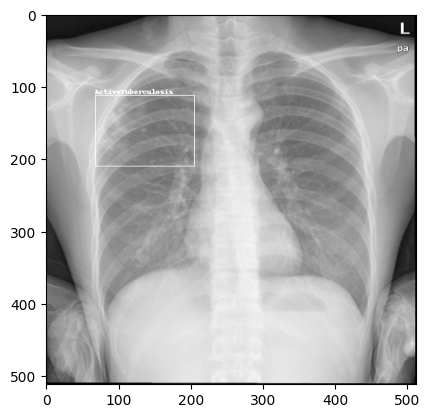

In [17]:
random.seed(0)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("annotations", "images").replace("txt", "png")
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)


# Partition the dataset

In [18]:
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"]
#annotations

In [19]:
# Read images and annotations
images = [os.path.join('images', x) for x in os.listdir('images')]
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"]

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)


# Started SMOTE

In [20]:
# Firstly, we must import some libs
import os
import numpy as np
import pandas as pd
import gc
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import json
import yaml
from shutil import copyfile
import matplotlib.pyplot as plt

import torch
from PIL import Image
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [21]:
#View the distributio of categories in traning data
import json
from collections import Counter
json_file_path = '/kaggle/input/tbx-11/TBX11K/annotations/json/TBX11K_train_only_tb.json'


data = json.load(open(json_file_path, 'r'))
dict_cat = {}
for cat in data["categories"]:
    dict_cat[cat["id"]]= cat["name"]
    print(dict_cat[cat["id"]])
list_cat = []
for ann in data["annotations"]:
    list_cat.append(dict_cat[ann["category_id"]])
Counter(list_cat)



ActiveTuberculosis
ObsoletePulmonaryTuberculosis
PulmonaryTuberculosis


Counter({'ActiveTuberculosis': 724, 'ObsoletePulmonaryTuberculosis': 178})

In [22]:
x_train_1.head()

NameError: name 'x_train_1' is not defined

In [23]:
# Split train dataset and test dataset according to annotation_id
X = pd.DataFrame(data["annotations"])
Y = pd.DataFrame(X["category_id"])
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.1,random_state=1,stratify = Y)
Counter(list(y_train["category_id"]))

print("X_TRAIN : ", x_train.count())
print("Y_TRAIN : ", y_train.count())
print(Counter(list_cat))

X_TRAIN :  id             811
image_id       811
category_id    811
iscrowd        811
area           811
bbox           811
width          811
height         811
dtype: int64
Y_TRAIN :  category_id    811
dtype: int64
Counter({'ActiveTuberculosis': 724, 'ObsoletePulmonaryTuberculosis': 178})


In [ ]:
#!cp -R /kaggle/input/tbx-11/TBX11K/annotations/json/TBX11K_train_only_tb.json /kaggle/working

In [22]:
""""
def convert_coco_json_to_csv(filename):
    import pandas as pd
    import json
    
    # COCO2017/annotations/instances_val2017.json
    s = json.load(open(filename, 'r'))
    out_file = filename[:-5] + '.csv'
    out = open(out_file, 'w')
    out.write('id,x1,y1,x2,y2,class_name,boxwidth,boxheight, imagewidth, imageheight, file_name\n')

    dictclass = {}
    for cat in s['categories']:
        catKey = cat['id']
        catValue = cat['name']
        dictclass.update({catKey:catValue}) 
    
    
    sdict = {} 
    all_ids = []
    for im in s['images']:
        all_ids.append(im['id'])
        aKey = im['id']
        aValue = im['file_name']
        sdict.update({aKey:aValue})
        
        #imagefile = im['file_name']
        #classlabel = imagefile.rsplit('/', 1)[0]

    all_ids_ann = []
    for ann in s['annotations']:
        image_id = ann['image_id']
        all_ids_ann.append(image_id)
        x1 = ann['bbox'][0]
        x2 = ann['bbox'][0] + ann['bbox'][2]
        y1 = ann['bbox'][1]
        y2 = ann['bbox'][1] + ann['bbox'][3]
        
        boxwidth = ann['bbox'][2]
        boxheight = ann['bbox'][3]
        classid = ann['category_id']
        imagewidth = ann['width']
        imageheight = ann['height']
        
        # Find the index of the value in the list for id and filename
        values = list(sdict.keys())
        index = values.index(image_id)
        # Get the key from the dictionary using the index
        fname = list(sdict.values())[index]
          
    
        # GET Class name from class dictionary for each annotation
        classname = list(dictclass.keys())
        indexclass = values.index(classid)
        # Get the key from the dictionary using the index
        classname = list(dictclass.values())[indexclass] 
        
        out.write('{},{},{},{},{},{},{},{},{},{},{}\n'.format(image_id, x1, y1, x2, y2, classname,boxwidth,boxheight, imagewidth, imageheight, fname))

    all_ids = set(all_ids)
    all_ids_ann = set(all_ids_ann)
    no_annotations = list(all_ids - all_ids_ann)
    # Output images without any annotations
    for image_id in no_annotations:
        #print(no_annotations)
        # get the filename from id and filename dictionary
        values = list(sdict.keys())
        index = values.index(image_id)
        #print(index)
        # Get the key from the dictionary using the index
        imagefilename = list(sdict.values())[index]
        
        # Get Class label by splitting the filename
        classlabel = imagefilename.rsplit('/', 1)[0]
         
        out.write('{},{},{},{},{},{},{},{},{},{},{}\n'.format(image_id, -1, -1, -1, -1, classlabel , -1 , -1,-1, -1, imagefilename))
    out.close()

    # Sort file by image id
    s1 = pd.read_csv(out_file)
    s1.sort_values('id', inplace=True)
    s1.to_csv(out_file, index=False)

In [ ]:
""""
convert_coco_json_to_csv('TBX11K_train_only_tb.json')


In [ ]:
""""
#x_test
x_train = pd.read_csv ('/kaggle/working/TBX11K_train_only_tb.csv')

#id	image_id	category_id	iscrowd	area	bbox	width	height
#0	1	1	1	0	1793	[381.8337097167969, 126.8733901977539, 40.2369...	512	512
#1	2	2	2	0	19866	[307.3073425292969, 62.050445556640625, 135.50...	512	512

In [24]:
x_train.count()
#x_train.class_name.unique()

id             811
image_id       811
category_id    811
iscrowd        811
area           811
bbox           811
width          811
height         811
dtype: int64

In [ ]:
""""
x_train_backup = x_train
x_train['newclass_name'] = x_train['class_name']
x_train.loc[x_train['class_name'] == 'ObsoletePulmonaryTuberculosis', 'newclass_name'] =  1
x_train.loc[x_train['class_name'] == 'ActiveTuberculosis', 'newclass_name'] =  0

In [ ]:
""""
# Round x1, x2, y1, and y2 columns to two decimal places
x_train['x1'] = x_train['x1'].round(2)
x_train['x2'] = x_train['x2'].round(2)
x_train['y1'] = x_train['y1'].round(2)
x_train['y2'] = x_train['y2'].round(2)

# Concatenate x1, y1, x2, and y2 into a bbox column with square brackets
x_train['bbox'] = x_train.apply(lambda row: f"[{row['x1']},{row['y1']},{row['x2']},{row['y2']}]", axis=1)

x_train.head()

In [ ]:
""""
# Drop x1, y1, x2, and y2 columns if needed
x_train = x_train.drop(columns=['x1', 'y1', 'x2', 'y2'])

In [ ]:
"""""
x_train = x_train.drop(columns=['class_name'])
x_train.head()

In [ ]:
""""
x_train = x_train.drop(columns=['newclass_name'])
x_train.head(2)

In [26]:
x_train.count()

id             811
image_id       811
category_id    811
iscrowd        811
area           811
bbox           811
width          811
height         811
dtype: int64

In [25]:
y_train

,category_id
282,1
147,1
176,1
594,1
545,1
...,...
690,1
73,1
875,2
242,1


In [27]:
#y_train.groupby('category_id').count()

y_train.category_id.value_counts()

category_id
1    651
2    160
Name: count, dtype: int64

In [ ]:
# SMOTE 
#Before SMOTE :  Counter({1: 651, 2: 160})
#After SMOTE :  Counter({1: 651, 2: 651})

# SMOTE ADASYN
#Before ADASYN SMOTE :  Counter({1: 651, 2: 160})
#length of X_TRAIN :  811
#After ADASYN SMOTE :  Counter({2: 680, 1: 651})
#length of X_SMOTE :  1331

In [ ]:
Counter(y_train.category_id)

In [28]:
from collections import Counter
from imblearn.over_sampling import ADASYN
counter_bef = Counter(y_train.category_id)
print("Before ADASYN SMOTE : ",counter_bef)
print("length of X_TRAIN : " , len(x_train['id']))
# Using the SOMTE to inflate the imbanlanced data, such as 'Belt'
x_train_only_id = pd.DataFrame(x_train['id'])
X_SMOTE, Y_SMOTE = ADASYN().fit_resample(x_train_only_id.values,y_train.values)
Counter(Y_SMOTE)

counter = Counter(Y_SMOTE)
print("After ADASYN SMOTE : ", counter)
print("length of X_SMOTE : " , len(X_SMOTE))

Before ADASYN SMOTE :  Counter({1: 651, 2: 160})
length of X_TRAIN :  811
After ADASYN SMOTE :  Counter({2: 680, 1: 651})
length of X_SMOTE :  1331


In [29]:
x_train_only_id.count()

id    811
dtype: int64

In [30]:
len(X_SMOTE)

1331

In [31]:
!pwd

/kaggle/working/Road_Sign_Dataset


In [32]:
x_train.head(2)

,id,image_id,category_id,iscrowd,area,bbox,width,height
282,283,197,1,0,10747,"[284.3558044433594, 39.35555648803711, 110.516...",512,512
147,148,106,1,0,8052,"[282.0473937988281, 83.0672607421875, 92.98458...",512,512


In [33]:
df_annid = pd.DataFrame(X_SMOTE,columns=['ann_id'])
df_annid.count()

ann_id    1331
dtype: int64

In [ ]:
#data["images"]

In [34]:
dict_annid[512]

NameError: name 'dict_annid' is not defined

In [35]:
# Storing some dictionaries, {annotation_id:nubers}; {image_id:images in train.json}
df_annid = pd.DataFrame(X_SMOTE,columns=['ann_id'])
print(df_annid.head())
# Storing the inflated annotations
dict_annid = {}
for i,row in df_annid.iterrows():
    annid = row['ann_id']
    if annid in dict_annid:
        dict_annid[annid] += 1
    else:
        dict_annid[annid] = 1
#print(dict_annid)
# Storing the imageid and its json data
dict_imgid = {}
for img in data["images"]:
    id = img['id']
    #print("Image id : ",img['id'])
    dict_imgid[id] = img
#print(dict_imgid[id])
    
#Image id :  1
#Image id :  2
#Image id :  3
#Image id :  4


   ann_id
0     283
1     148
2     177
3     595
4     546


In [ ]:
#dict_annid

#283: 2,
 #148: 1,
 #177: 1,
 #595: 2,
 #546: 1,
 #741: 1,


In [33]:
len(dict_annid)

832

In [ ]:
len(dict_imgid)

In [ ]:
""""
dict_imgid

{1: {'id': 1,
  'file_name': 'tb/tb0005.png',
  'width': 512,
  'height': 512,
  'date_captured': '2020-06-24 12:42:40.548139',
  'license': 1,
  'coco_url': '',
  'flickr_url': ''},
""""

In [42]:
data_new ={}

data_new['categories']= [{'id': 1, 'name': 'ActiveTuberculosis', 'supercategory': 'Tuberculosis'},
 {'id': 2,
  'name': 'ObsoletePulmonaryTuberculosis',
  'supercategory': 'Tuberculosis'}]

In [43]:
# Transfer the categories to continuous ids
cate_id_map = {}
for i, category in enumerate(data_new['categories']):     
    cate_id_map[category['id']] = i
    #id_cat[i] = category['id']
cate_id_map

{1: 0, 2: 1}

In [37]:
# convert the bounding box from COCO to YOLO format.
def cc2yolo_bbox(img_width, img_height, bbox):
    dw = 1. / img_width
    dh = 1. / img_height
    x = bbox[0] + bbox[2] / 2.0
    y = bbox[1] + bbox[3] / 2.0
    w = bbox[2]
    h = bbox[3]
 
    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return (x, y, w, h)

In [38]:
# Create the path for storing the txt files for yolov5
yolo_anno_path = '/kaggle/working/training/yolo_anno/'
if not os.path.exists(yolo_anno_path):
    os.makedirs(yolo_anno_path)

In [39]:
data['annotations'][0]

{'id': 1,
 'image_id': 1,
 'category_id': 1,
 'iscrowd': 0,
 'area': 1793,
 'bbox': [381.8337097167969,
  126.8733901977539,
  40.236907958984375,
  44.565773010253906],
 'width': 512,
 'height': 512}

In [40]:
dict_imgid[1]

{'id': 1,
 'file_name': 'tb/tb0005.png',
 'width': 512,
 'height': 512,
 'date_captured': '2020-06-24 12:42:40.548139',
 'license': 1,
 'coco_url': '',
 'flickr_url': ''}

In [ ]:
#dict_imgid

{1: {'id': 1,
  'file_name': 'tb/tb0005.png',
  'width': 512,
  'height': 512,
  'date_captured': '2020-06-24 12:42:40.548139',
  'license': 1,
  'coco_url': '',
  'flickr_url': ''},
 2: {'id': 2,

In [44]:
# Building the train and validation images list
dict_imgid_count = {} # this dictionary records how many images are the same
f = open('/kaggle/working/train_valid.csv','w')
f.write('id,file_name,split\n')
for i in tqdm(range(len(data['annotations']))):
    annid = data['annotations'][i]['id']
    img_id = data['annotations'][i]['image_id']    
    filename = dict_imgid[img_id]['file_name']
    #print(filename)
    yolo_txt_name = filename.split('.')[0] + '.txt' #remove .jpg
    yolo_txt_name = yolo_txt_name.split('/')[1]
    img_width = dict_imgid[img_id]['width']
    img_height = dict_imgid[img_id]['height']
    if annid in dict_annid:
        temp_count = 1
        if img_id in dict_imgid_count:
            dict_imgid_count[img_id] += 1
            temp_count = dict_imgid_count[img_id]
        else:
            dict_imgid_count[img_id] = 1        
        arr = str(filename).split('.')
        filename = arr[0] + '_' + str(temp_count) + '.' + arr[1]
        f.write('{},{},train\n'.format(img_id, filename))    
    
    yolo_txt_file = open(os.path.join(yolo_anno_path, yolo_txt_name), 'w')    
    for anno in data['annotations']:
        if anno['image_id'] == img_id:
            yolo_bbox = cc2yolo_bbox(img_width, img_height, anno['bbox']) # "bbox": [x,y,width,height]        
            yolo_txt_file.write('{} {} {} {} {}\n'.format(cate_id_map[anno['category_id']], yolo_bbox[0], yolo_bbox[1], yolo_bbox[2], yolo_bbox[3]))
    yolo_txt_file.close()

# write validation files into the file train.csv
for i,row in x_test.iterrows():
    img_id = row['image_id']
    filename = dict_imgid[img_id]['file_name']
    f.write('{},{},valid\n'.format(img_id, filename))

f.close()

100%|██████████| 902/902 [00:00<00:00, 4776.88it/s]


In [45]:
x_test.head(2)

,id,image_id,category_id,iscrowd,area,bbox,width,height
430,431,287,1,0,17693,"[327.72393798828125, 78.5093994140625, 137.823...",512,512
378,379,255,1,0,19797,"[280.4891662597656, 64.58258819580078, 117.748...",512,512


In [46]:
# Then we got the training and tesing dataframe
df = pd.read_csv('/kaggle/working/train_valid.csv')
print(df)

      id        file_name  split
0      1  tb/tb0005_1.png  train
1      2  tb/tb0007_1.png  train
2      2  tb/tb0007_2.png  train
3      3  tb/tb0012_1.png  train
4      4  tb/tb0017_1.png  train
..   ...              ...    ...
931  469    tb/tb0925.png  valid
932   22    tb/tb0050.png  valid
933  495    tb/tb0983.png  valid
934  132    tb/tb0262.png  valid
935  436    tb/tb0865.png  valid

[936 rows x 3 columns]


In [47]:
row = df.loc[5]
print(row)
name_count = row.file_name.split('.')[0]
print("name count : ", name_count)
name = name_count.split('_')[0]
print("name : ", name)
name = name_count.split('/')[1]
print(name)
#name = name_count.split('_')[0]
    #if i<10:

id                         5
file_name    tb/tb0018_1.png
split                  train
Name: 5, dtype: object
name count :  tb/tb0018_1
name :  tb/tb0018
tb0018_1


In [48]:
row = df.loc[5]
print(row)
#name = row.file_name.split('.')[0]
name_file = row.file_name.split('/')[1]
print("name file : ", name_file)
name_count = name_file.split('.')[0]
print("name count : ", name_count)
name = name_count.split('_')[0]
print("name  : ", name)

id                         5
file_name    tb/tb0018_1.png
split                  train
Name: 5, dtype: object
name file :  tb0018_1.png
name count :  tb0018_1
name  :  tb0018


In [49]:
# Preparing the data and structure directories for Yolov5
os.makedirs('/kaggle/working/training/images/train', exist_ok=True)
os.makedirs('/kaggle/working/training/images/valid', exist_ok=True)
#
os.makedirs('/kaggle/working/training/labels/train', exist_ok=True)
os.makedirs('/kaggle/working/training/labels/valid', exist_ok=True)

In [50]:
# copy the image files and annotations txt files to relevant folders
for i in tqdm(range(len(df))):
    row = df.loc[i]
    #name = row.file_name.split('.')[0]
    name_file = row.file_name.split('/')[1]
    name_count = name_file.split('.')[0]
    name = name_count.split('_')[0]
    
    #if i<10:
    #    print(name)
    if row.split == 'train':        
        copyfile(f'/kaggle/input/tbx-11/TBX11K/imgs/tb/{name}.png', f'/kaggle/working/training/images/train/{name_count}.png')
        copyfile(f'/kaggle/working/training/yolo_anno/{name}.txt', f'/kaggle/working/training/labels/train/{name_count}.txt')
    else:        
        copyfile(f'/kaggle/input/tbx-11/TBX11K/imgs/tb/{name}.png', f'/kaggle/working/training/images/valid/{name}.png')
        copyfile(f'/kaggle/working/training/yolo_anno/{name}.txt', f'/kaggle/working/training/labels/valid/{name}.txt')

100%|██████████| 936/936 [00:01<00:00, 590.59it/s]


In [ ]:
# Let's install Yolov5 to exploring a wonderful trip 
%cd /kaggle/working
!git clone https://github.com/ultralytics/yolov5
%cd /kaggle/working/yolov5
%pip install -r requirements.txt

In [ ]:
# Firstly we create the yaml file
data_yaml = dict(
    train = '/kaggle/working/training/images/train/',
    val = '/kaggle/working/training/images/valid/',
    nc = 5,
    names = ['ActiveTuberculosis', 'ObsoletePulmonaryTuberculosis']
)

# we will make the file under the yolov5/data/ directory.
with open('/kaggle/working/yolov5/data/data.yaml', 'w') as outfile:
    yaml.dump(data_yaml, outfile, default_flow_style=True)
    
%cat /kaggle/working/yolov5/data/data.yaml # show your YAML file

In [ ]:
import wandb
wandb.login()

In [ ]:
# For showing the example code, I only select yolov5s model and 1 epoch to run.
BATCH_SIZE = 16
EPOCHS = 10 
MODEL = 'yolov5m.pt' # this specify the model for training, you can use yolov5s.pt, yolov5l.pt, yolov5x.pt, etc.

In [ ]:
# GO TRAIN
!python train.py --batch {BATCH_SIZE} \
                 --epochs {EPOCHS} \
                 --data data.yaml \
                 --weights {MODEL} \
                 --project tbx_smote\
                 --name tbx_smote_medium_ADASYN

In [ ]:
# For showing the example code, I only select yolov5s model and 1 epoch to run.
BATCH_SIZE = 16
EPOCHS = 10 
MODEL = 'yolov5l.pt'

In [ ]:
# GO TRAIN
!python train.py --batch {BATCH_SIZE} \
                 --epochs {EPOCHS} \
                 --data data.yaml \
                 --weights {MODEL} \
                 --project tbx_smote\
                 --name tbx_smote_large_ADASYN



# Inference

In [ ]:
!cp -R /kaggle/input/tbx-11/TBX11K/annotations/json/TBX11K_val_only_tb.json /kaggle/working/

In [ ]:
%cd ..
!pwd

In [ ]:
convert_coco_json_to_csv('/kaggle/working/TBX11K_val_only_tb.json')

In [ ]:
df_rach = pd.read_csv('/kaggle/working/TBX11K_val_only_tb.csv')

In [ ]:
df_rach.columns = df_rach.columns.str.replace(' ', '')

In [ ]:
df_rach.columns

In [ ]:
df_rach['file_name']

In [ ]:
df_rach['file_name_new'] = df_rach['file_name'].str.split('/').str[1]
df_rach.head(2)

In [ ]:
#df_rach[['id','file_name_new' ]]

In [ ]:
# In the Dev phase, we will only use the valid data for predicition. 
# Don't forget change it to test data in the Final pahse.
#valid_df = pd.read_csv('/kaggle/input/c/cowboyoutfits/valid.csv')
#test_df = pd.read_csv('/kaggle/input/c/cowboyoutfits/test.csv')

valid_df = df_rach[['id','file_name_new' ]]
valid_df.head()

In [ ]:
# make directory to store the validation data.
os.makedirs('/kaggle/working/inference/valid', exist_ok=True)
os.makedirs('/kaggle/working/inference/test', exist_ok=True)

In [ ]:
# copy the validation image to inference folder for detection process
for i in tqdm(range(len(valid_df))):
    row = valid_df.loc[i]    
    name = row.file_name_new.split('.')[0]
    copyfile(f'/kaggle/input/tbx-11/TBX11K/imgs/tb/{name}.png', f'/kaggle/working/inference/valid/{name}.png')

In [ ]:
VALID_PATH = '/kaggle/working/inference/valid/'
#MODEL_PATH = '/kaggle/working/yolo/cowboy-detection/exp5/weights/best.pt'
#MODEL_PATH = '/kaggle/input/bestmodelweights/exp8-m-100ep-withonesplit-best.pt'
MODEL_PATH  =  '/kaggle/working/yolov5/tbx_smote/tbx_smote_large_ADASYN/weights/best.pt'
#IMAGE_PATH = '/kaggle/input/cowboyoutfits/images/'

In [ ]:
#%cd ..
!pwd

In [ ]:
%cd /kaggle/working/yolov5

In [ ]:
# Let's begin the amazing time to detect the cowboy outfits objects
!python detect.py --weights {MODEL_PATH} \
                  --source {VALID_PATH} \
                  --conf 0.20 \
                  --iou-thres 0.45 \
                  --save-txt \
                  --save-conf \
                  --augment

In [ ]:
# If you have run more than one times of detect.py, 
# the name of 'exp' in the path will be changed for storing the detecting results.
PRED_PATH = '/kaggle/working/yolov5/runs/detect/exp7/labels/'

# list our prediction files path
prediction_files = os.listdir(PRED_PATH)
print('Number of test images with detections: ', len(prediction_files))

In [ ]:
Image.open('/kaggle/working/inference/valid/tb0950.png')

In [ ]:
%cd /kaggle/working/yolov5/runs/detect/exp5/
!ls

In [ ]:
Image.open('/kaggle/working/yolov5/runs/detect/exp/tb0950.png')

# End SMOTE

In [ ]:
!mkdir images/train 
!mkdir images/val 
!mkdir images/test 

!mkdir annotations/train 
!mkdir annotations/val 
!mkdir annotations/test

In [ ]:
len(os.listdir('/kaggle/working/Road_Sign_Dataset/images/train'))
#len(os.listdir('/kaggle/working/Road_Sign_Dataset/images/test'))
#len(os.listdir('/kaggle/working/Road_Sign_Dataset/images/val'))

In [ ]:
#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, '/kaggle/working/Road_Sign_Dataset/images/train')
move_files_to_folder(val_images, '/kaggle/working/Road_Sign_Dataset/images/val/')
move_files_to_folder(test_images, '/kaggle/working/Road_Sign_Dataset/images/test/')
move_files_to_folder(train_annotations, '/kaggle/working/Road_Sign_Dataset/annotations/train/')
move_files_to_folder(val_annotations, '/kaggle/working/Road_Sign_Dataset/annotations/val/')
move_files_to_folder(test_annotations, '/kaggle/working/Road_Sign_Dataset/annotations/test/')
!mv annotations labels
%cd ../

In [ ]:
%cd /kaggle/working/Road_Sign_Dataset/
!ls

In [ ]:
len(os.listdir('/kaggle/working/Road_Sign_Dataset/labels/train/'))


In [ ]:
!wget -P data/ https://gist.githubusercontent.com/ayooshkathuria/bcf7e3c929cbad445439c506dba6198d/raw/f437350c0c17c4eaa1e8657a5cb836e65d8aa08a/road_sign_data.yaml


# INSTALL

In [ ]:
!pwd

In [ ]:
!git clone https://github.com/WongKinYiu/yolov7.git  #&> /dev/null

In [ ]:
%cd yolov7

In [ ]:
!pip install -r requirements.txt &> /dev/null

In [ ]:
!wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-e6e.pt

In [ ]:
!wget https://raw.githubusercontent.com/tkeldenich/How_to_use_YOLOv7_Tutorial/main/man_cafe.jpg

In [ ]:
from PIL import Image
im = Image.open('man_cafe.jpg')
im

In [ ]:
!python detect.py --weights yolov7-e6e.pt --source ./man_cafe.jpg

In [ ]:
im_res1 = Image.open('./runs/detect/exp/man_cafe.jpg')
im_res1

In [ ]:
!python detect.py --weights yolov7-e6e.pt --conf 0.60 --img-size 640 --source ./man_cafe.jpg

In [ ]:
im_res2 = Image.open('./runs/detect/exp2/man_cafe.jpg')
im_res2

In [ ]:
!wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-tiny.pt

In [ ]:
!python detect.py --weights yolov7-tiny.pt --conf 0.25 --img-size 640 --source ./man_cafe.jpg

In [ ]:
im_res3 = Image.open('./runs/detect/exp3/man_cafe.jpg')
im_res3

In [ ]:
!cp -R /kaggle/working/Road_Sign_Dataset/data/road_sign_data.yaml /kaggle/working/Road_Sign_Dataset/yolov7/data/

In [ ]:
!pwd

In [ ]:
!pip install wandb

In [ ]:
import wandb
wandb.login()

In [ ]:
train: ../Road_Sign_Dataset/images/train/ 
val:  ../Road_Sign_Dataset/images/val/
test: ../Road_Sign_Dataset/images/test/

# number of classes
nc: 4

# class names
names: ["trafficlight","stop", "speedlimit","crosswalk"]

In [ ]:
yamltext = """
train: /kaggle/working/Road_Sign_Dataset/images/train/ 
val:  /kaggle/working/Road_Sign_Dataset/images/val/
test: /kaggle/working/Road_Sign_Dataset/images/test/

# number of classes
nc: 2

# class names
names: ["ActiveTuberculosis","ObsoletePulmonaryTuberculosis"]

"""

with open("/kaggle/working/Road_Sign_Dataset/yolov7/data/road_sign_data.yaml", 'w') as file:
    file.write(yamltext)

#%cat /kaggle/working/data/data.yaml


!cat /kaggle/working/Road_Sign_Dataset/yolov7/data/road_sign_data.yaml

In [ ]:
%cd /kaggle/working/Road_Sign_Dataset/yolov7

In [ ]:
len(os.listdir('/kaggle/working/Road_Sign_Dataset/images/train/'))

# Train for 60 Epochs

In [ ]:
class_weight_0=1.0
#class_weight_1=num_samples_class_0 / num_samples_class_1

class_weight_1= 972 / 269

print(class_weight_0)
print(class_weight_1)

In [ ]:
%cd yolov7

In [ ]:
!python train.py --img-size 512 --cfg cfg/training/yolov7.yaml --hyp data/hyp.scratch.custom.yaml --batch 8 --epochs 10 --data data/road_sign_data.yaml --weights yolov7-e6e.pt --workers 24 --cls_weights $class_weight_0 $class_weight_1 --name yolo_tbx31_1

# Train for 120 Epochs

In [ ]:
!python train.py --img-size 512 --cfg cfg/training/yolov7.yaml --hyp data/hyp.scratch.custom.yaml --batch 8 --epochs 130 --data data/road_sign_data.yaml --weights yolov7-e6e.pt --workers 24 --name yolo_det31Aug_130

In [ ]:
!pwd

In [ ]:
!python detect.py --source /kaggle/working/Road_Sign_Dataset/images/test/ --weights runs/train/yolo_tbx31_1/weights/best.pt --conf 0.05 --name yolo_tbx31_1

In [ ]:
detections_dir = "runs/detect/yolo_tbx31_1/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

# No weights

In [ ]:
!python train.py --img-size 512 --cfg cfg/training/yolov7.yaml --hyp data/hyp.scratch.custom.yaml --batch 8 --epochs 10 --data data/road_sign_data.yaml --weights '' --workers 24 --name yolo_det31Aug_noweights


#yolov7-e6e.pt 

In [ ]:
!python test.py --weights runs/train/yolo_road_det3/weights/best.pt --data road_sign_data.yaml --task test --name yolo_det

# Inference for 130 Epochs

In [ ]:
!python detect.py --source /kaggle/working/Road_Sign_Dataset/images/test/ --weights runs/train/yolo_det31Aug_130/weights/best.pt --conf 0.05 --name yolo_road_det5



In [ ]:
detections_dir = "runs/detect/yolo_road_det52/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))